# Installing GDAL

In [ ]:
!apt-get update
!apt-get install libgdal-dev -y
!apt-get install python-gdal -y
!apt-get install python-numpy python-scipy -y
!pip install rasterio
!pip install fiona
!pip install geopandas
import gdal 

# Importing Libraries

In [4]:
from tqdm.autonotebook import tqdm
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import rasterio
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

print("TF version:", tf.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  """Entry point for launching an IPython kernel.


TF version: 2.2.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available


# Copying over data from Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [4]:
!cp "/content/drive/Shared drives/SIO and E4E Mangroves /Data/Visualizations/Orthos 5.22.20/Orto_Puerto_Gata_Tiles.zip" .
!ls

drive  Orto_Puerto_Gata_Tiles.zip  sample_data


In [5]:
!rm -rf /content/images/images/

In [ ]:
!unzip Orto_Puerto_Gata_Tiles.zip
!mkdir /content/images
!mkdir /content/images/images
!mv *.tif /content/images/images/

In [7]:
#downloading model file
!cp "/content/drive/Shared drives/SIO and E4E Mangroves /Data/Machine Learning/Models/mvnmv4_merced_bright.zip" .
!unzip mvnmv4_merced_bright.zip

Archive:  mvnmv4_merced_bright.zip
   creating: mvnmv4_merced/
   creating: mvnmv4_merced/assets/
   creating: mvnmv4_merced/variables/
  inflating: mvnmv4_merced/variables/variables.index  
  inflating: mvnmv4_merced/variables/variables.data-00001-of-00002  
  inflating: mvnmv4_merced/variables/variables.data-00000-of-00002  
  inflating: mvnmv4_merced/saved_model.pb  


# Classification Parameters

In [8]:
from tensorflow.keras.models import load_model

#Set model location
output_file = "results.csv"
model = "/content/mvnmv4_merced/"
image_directory = "/content/images"

model = load_model(model)

In [12]:
#Since the original model outputs the values from the last dense layer (no final activation), we need to definte the sigmoid function for predicted class conditional probabilities
def sigmoid(x):
    return 1/(1 + np.exp(-x)) 

# Classifying Images

In [9]:
#Read images using keras and split into batches
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
data_gen = image_generator.flow_from_directory(directory=image_directory,
                                                     batch_size=32,
                                                     shuffle=False,
                                                     target_size=(256, 256))

Found 2923 images belonging to 1 classes.


In [13]:
#Set up dataframe that will hold classifications
column_names = ["prediction","p_0","p_1","filename"]
result_df = pd.DataFrame(columns=column_names)

#predict probabilities from model for the batches
predictions = model.predict(data_gen)

#associate filenames and classification for each prediction
for i,prediction in tqdm(enumerate(predictions)):
    result_df.loc[i,"filename"] = data_gen.filenames[i]

    #calculating predictions 
    result_df.loc[i,"p_0"] = sigmoid(prediction[0])
    result_df.loc[i,"p_1"] = sigmoid(prediction[1])
    
    #getting final class prediction
    result_df.loc[i,"prediction"] = np.argmax(prediction)

In [29]:
filename = "prob_" + os.path.basename(result_df.loc[0,"filename"])
os.path.join("images", os.path.dirname(result_df.loc[0,"filename"]), filename)

'images/images/prob_Orto_Puerto_Gata_01_19.tif'

# Generating probability tiles 

Below also includes a good example for how to copy projection information from tile to tile

In [35]:
for index, sample in tqdm(result_df.iterrows()):
    #loading original image
    original = os.path.abspath(os.path.join("images", sample["filename"]))
    img = rasterio.open(original)

    #creating new raster mask with pixel values of conditional probability
    mask = sample["p_0"] * np.ones(shape=(img.width, img.height))

    #saving file output to new file
    filename = "prob_" + os.path.basename(sample["filename"])
    output = os.path.abspath(os.path.join("images", os.path.dirname(sample["filename"]), filename))
    #creates new file with projection of past image
    with rasterio.open(output,'w',driver='GTiff',height=img.height,width=img.width,count=1,dtype=mask.dtype,crs='+proj=latlong',transform=img.transform,) as dst:dst.write(mask, 1)

# Moving files to folders

In [36]:
dest_folders = []
#Organize tiles into folders
for index, row in tqdm(result_df.iterrows()):
	cur_file = "/content/images/" + row['filename']
	cur_file = cur_file.replace("jpg","tif",2)
	classification = row['prediction'] 

    #set destination folder, and creates the folder if it doesn't exist
	dest_folder = os.path.join(os.path.abspath(image_directory),str(classification))
	dest_folders.append(dest_folder)
	if os.path.exists(dest_folder) == False:
		os.mkdir(dest_folder)
	dest = os.path.join(dest_folder,os.path.basename(cur_file))
 
    #moves file
	src = cur_file
	os.rename(src, dest)

# Visualization and uploading data to drive

In [37]:
#recombines classified tiles for each class
!gdal_merge.py -o /content/1.tif /content/images/1/*
!gdal_merge.py -o /content/0.tif /content/images/0/*

#probability tiles remain unmoved, so just get all the leftover tiles
!gdal_merge.py -o /content/p.tif /content/images/images/*

0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


In [51]:
!gdal_polygonize.py /content/1.tif -f "ESRI Shapefile" -b 4 1.shp
!gdal_polygonize.py /content/0.tif -f "ESRI Shapefile" -b 4 0.shp

Creating output 1.shp of format ESRI Shapefile.
0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output 0.shp of format ESRI Shapefile.
0...10...20...30...40...50...60...70...80...90...100 - done.


In [9]:
#copies orthomosaics generated to the drive
!cp "/content/1.tif" "/content/drive/Shared drives/SIO and E4E Mangroves /Data/Visualizations/Orthos 5.22.20/Orto_Puerto_Gatanm_v4bright.tif"
!cp "/content/0.tif" "/content/drive/Shared drives/SIO and E4E Mangroves /Data/Visualizations/Orthos 5.22.20/Orto_Puerto_Gatam_v4bright.tif"
!cp "/content/p.tif" "/content/drive/Shared drives/SIO and E4E Mangroves /Data/Visualizations/Orthos 5.22.20/Orto_Puerto_Gata_prob_v4bright.tif"

CAUTION: Keep in mind that these will crash your instance if the orthmosaics are above ~2GB, so please be careful with the file sizes!


In [2]:
from descartes import PolygonPatch
from rasterio.plot import show
import matplotlib as mpl
import geopandas
import fiona

#function for fixing shapefiles to only create polygons around the the specified class
def fix_shp(filename):
    shp = geopandas.read_file(filename)
    for index, feature in tqdm(shp.iterrows()):
        if feature["DN"] == 0:
            shp.drop(index, inplace=True)
    shp.to_file(filename)
    return shp

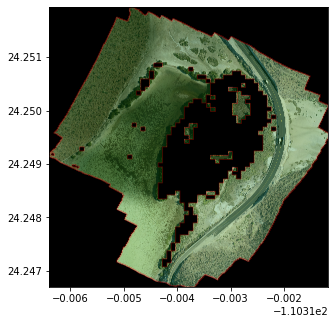

In [7]:
src = rasterio.open("1.tif")
shp = fix_shp("1.shp")

fig, ax = plt.subplots(figsize=(5, 10))
rasterio.plot.show(src, ax=ax)
shp.plot(ax=ax, facecolor='green', edgecolor='red', alpha=0.25)

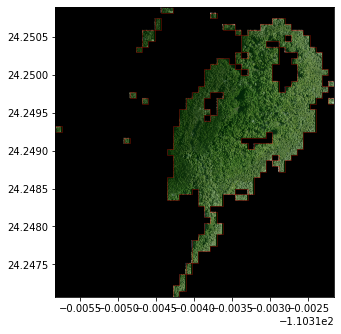

In [8]:
src = rasterio.open("0.tif")
shp = fix_shp("0.shp")

fig, ax = plt.subplots(figsize=(5, 10))
rasterio.plot.show(src, ax=ax)
shp.plot(ax=ax, facecolor='green', edgecolor='red', alpha=0.25)

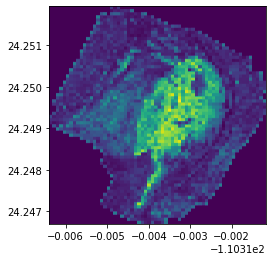

In [40]:
src = rasterio.open("p.tif")
rasterio.plot.show(src,cmap='viridis')